In [1]:
from collections.abc import Callable

import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous.fitzhugh import FitzhughNagumo
from einops import rearrange
from jaxtyping import Array, Float, PRNGKeyArray


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

# Calculate exmple trajectory for the Fitzhugh-Nagumo system

In [2]:
ode = FitzhughNagumo()

u0 = jnp.asarray([1.0, 0.0])
t = jnp.linspace(0, 100, 1000)
sol = dfx.diffeqsolve(
    dfx.ODETerm(ode.rhs),
    dfx.Tsit5(),
    t[0],
    t[-1],
    None,
    u0,
    stepsize_controller=dfx.PIDController(rtol=1e-6, atol=1e-6),
    saveat=dfx.SaveAt(ts=t),
)

Text(0, 0.5, '$y$')

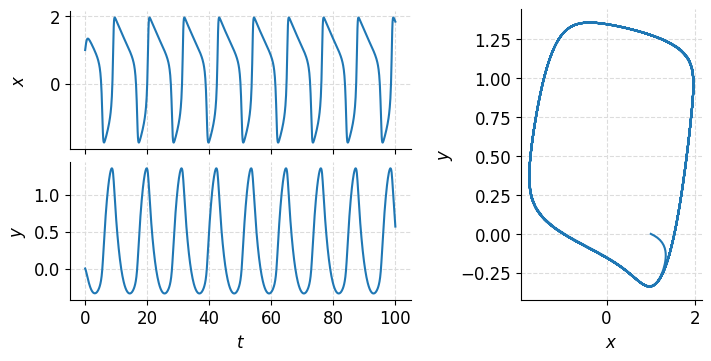

In [3]:
fig = plt.figure(figsize=(7, 3.5), layout="constrained")
subfigs = fig.subfigures(1, 2, width_ratios=(1.5, 1), wspace=0.05)
axes = subfigs[0].subplots(2, 1, sharex=True)
for i, (ax, y_name) in enumerate(zip(axes, ("x", "y"))):
    ax.plot(t, sol.ys[:, i])
    ax.set_ylabel(f"${y_name}$")
axes[-1].set_xlabel("$t$")
subfigs[0].align_ylabels()

ax = subfigs[1].subplots(1, 1)
ax.plot(*sol.ys.T)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")


# Create training dataset

In [4]:
n_trajs = 2000
t = jnp.linspace(0, 50, 1000)


def solve_single(
    ode,
    ts: Float[Array, " time"],
    u0: Float[Array, " dim"],
    rtol: float = 1e-6,
    atol: float = 1e-6,
    solver: dfx.AbstractSolver = dfx.Tsit5(),
):
    sol: dfx.Solution = dfx.diffeqsolve(
        dfx.ODETerm(ode.rhs),
        solver,
        ts[0],
        ts[-1],
        None,
        u0,
        stepsize_controller=dfx.PIDController(rtol=rtol, atol=atol),
        saveat=dfx.SaveAt(ts=t),
    )
    return sol.ys


u0_train = jax.random.uniform(
    jax.random.key(0), (n_trajs, ode.dim), minval=-3, maxval=3
)
u_train = eqx.filter_vmap(solve_single, in_axes=(None, None, 0))(ode, t, u0_train)
print(u_train.shape)

(2000, 1000, 2)


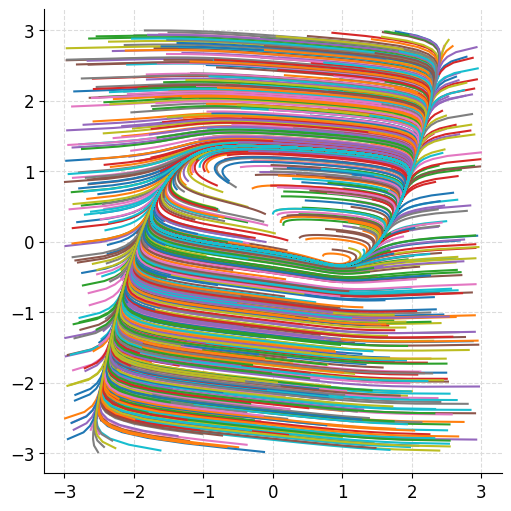

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(0, len(u_train), 2):
    ax.plot(*u_train[i].T)

In [6]:
import math


class LatentDynamicsModel(eqx.Module):
    encoder: eqx.nn.MLP
    decoder: eqx.nn.MLP
    linear_coeffs: Float[Array, "latent_dim latent_dim"]
    obs_dim: int = eqx.field(static=True)
    latent_dim: int = eqx.field(static=True)

    def __init__(
        self,
        obs_dim: int,
        latent_dim: int,
        depth_encoder: int,
        depth_decoder: int,
        width_encoder: int,
        width_decoder: int,
        activation: Callable[[Array], Array] = jax.nn.gelu,
        *,
        key: PRNGKeyArray,
    ):
        keys = jax.random.split(key, 3)
        lim = 1.0 / math.sqrt(latent_dim)
        self.linear_coeffs = jax.random.uniform(
            keys[0], (latent_dim, latent_dim), minval=-lim, maxval=lim
        )
        self.encoder = eqx.nn.MLP(
            obs_dim, latent_dim, width_encoder, depth_encoder, activation, key=keys[1]
        )
        self.decoder = eqx.nn.MLP(
            latent_dim, obs_dim, width_decoder, depth_decoder, activation, key=keys[2]
        )
        self.obs_dim = obs_dim
        self.latent_dim = latent_dim

    def to_latent(
        self, x: Float[Array, " {self.obs_dim}"]
    ) -> Float[Array, " {self.latent_dim}"]:
        return self.encoder(x)

    def to_observation(
        self, z: Float[Array, " {self.latent_dim}"]
    ) -> Float[Array, " {self.obs_dim}"]:
        return self.decoder(z)

    def solve_latent(
        self, ts: Float[Array, " times"], z0: Float[Array, " {self.latent_dim}"]
    ) -> Float[Array, "time {self.latent_dim}"]:
        Adt: Float[Array, "time {self.latent_dim} {self.latent_dim}"] = (
            self.linear_coeffs * rearrange(ts - ts[0], "time -> time 1 1")
        )
        exp_Adt: Float[Array, "time {self.latent_dim} {self.latent_dim}"] = (
            jax.scipy.linalg.expm(Adt)
        )
        return exp_Adt @ z0

    def __call__(
        self, ts: Float[Array, " times"], x0: Float[Array, " {self.obs_dim}"]
    ) -> Float[Array, "times {self.obs_dim}"]:
        z_t = self.solve_latent(ts, self.to_latent(x0))
        return jax.vmap(self.to_observation)(z_t)

In [12]:
latent_model = LatentDynamicsModel(
    obs_dim=ode.dim,
    latent_dim=20,
    depth_encoder=3,
    depth_decoder=3,
    width_encoder=20,
    width_decoder=20,
    key=jax.random.key(0),
)

In [13]:
u_pred = eqx.filter_vmap(latent_model, in_axes=(None, 0))(t, u_train[:, 0])
u_pred.shape

(2000, 1000, 2)

(-3.5, 3.5)

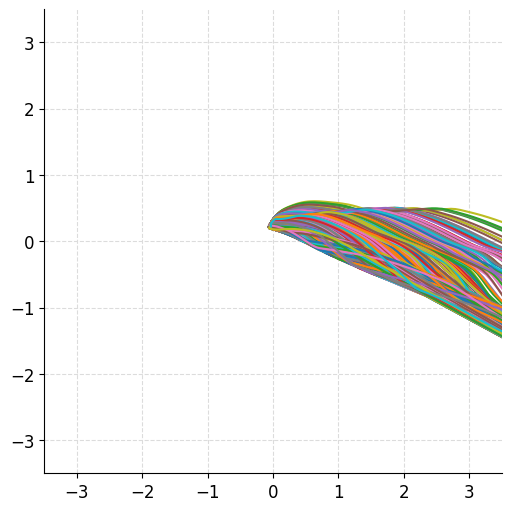

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(0, len(u_pred), 2):
    ax.plot(*u_pred[i].T)
ax.set_xlim((-3.5, 3.5))
ax.set_ylim((-3.5, 3.5))

In [15]:
from dynamics_discovery.data.dataset import TimeSeriesDataset
from dynamics_discovery.data.loaders import RandomSampleBatching, SegmentLoader


dataset = TimeSeriesDataset(t, u_train)
dataset

TimeSeriesDataset(t=f64[2000,1000](numpy), u=f64[2000,1000,2](numpy))

In [30]:
loader = SegmentLoader(
    dataset, segment_length=200, batch_strategy=RandomSampleBatching(batch_size=512)
)
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)

In [31]:
batch_pred = eqx.filter_vmap(latent_model)(batch[0], batch[1][:, 0])

(-3.5, 3.5)

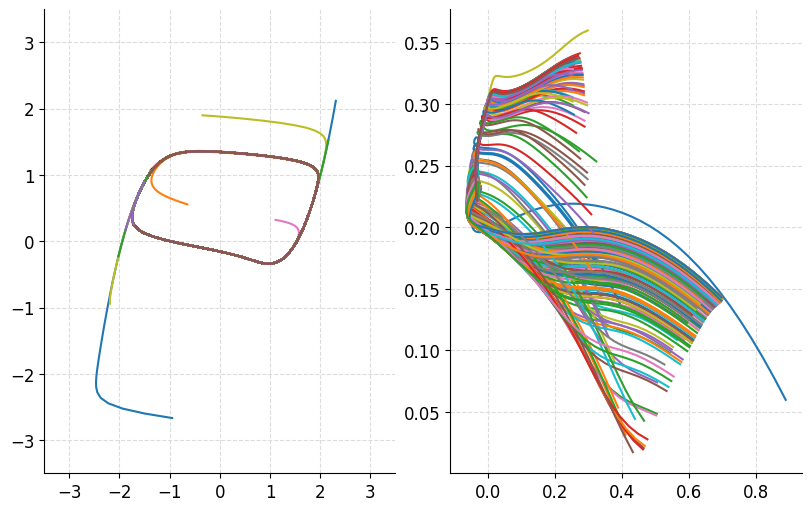

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
for i in range(0, len(batch[1]), 2):
    axes[0].plot(*batch[1][i].T)
    axes[1].plot(*batch_pred[i].T)
axes[0].set_xlim((-3.5, 3.5))
axes[0].set_ylim((-3.5, 3.5))

In [33]:
def loss(model, batch, args=None):
    t_batch: Float[Array, "batch time"]
    x_batch: Float[Array, "batch time dim"]
    t_batch, x_batch = batch
    x_pred: Float[Array, "batch time dim"] = eqx.filter_vmap(model)(
        t_batch, x_batch[:, 0]
    )
    mse = jnp.mean((x_batch - x_pred) ** 2)

    x_ae = jax.vmap(jax.vmap(lambda v: model.to_observation(model.to_latent(v))))(
        x_batch
    )
    loss_identity = jnp.mean((x_batch - x_ae) ** 2)

    return mse + loss_identity, {"mse": mse, "identity_loss": loss_identity}

In [34]:
loss(latent_model, batch)

(Array(2.10055521, dtype=float64),
 {'mse': Array(1.04273937, dtype=float64),
  'identity_loss': Array(1.05781584, dtype=float64)})

In [35]:
import optax
from dynamics_discovery.training import VanillaTrainer


trainer = VanillaTrainer(
    optax.adamw(learning_rate=1e-3),
    max_epochs=5000,
    wandb_entity="jhko725",
    wandb_project="isochron",
)

In [36]:
model_trained, loss_history = trainer.train(
    latent_model, loader, loss, config={"model": []}
)

<function loss at 0x14522bbd9760>
_ValueAndGradWrapper(_fun=<function loss>, _has_aux=True, _gradkwargs={})
step=0, loss=Array(2.10055521, dtype=float64)
step=1, loss=Array(2.07775119, dtype=float64)
step=2, loss=Array(2.08121495, dtype=float64)
step=3, loss=Array(2.06870863, dtype=float64)
step=4, loss=Array(2.04510083, dtype=float64)
step=5, loss=Array(2.0433632, dtype=float64)
step=6, loss=Array(2.03041688, dtype=float64)
step=7, loss=Array(2.03609751, dtype=float64)
step=8, loss=Array(2.02523595, dtype=float64)
step=9, loss=Array(2.00399456, dtype=float64)
step=10, loss=Array(1.99371398, dtype=float64)
step=11, loss=Array(1.99811762, dtype=float64)
step=12, loss=Array(1.97191367, dtype=float64)
step=13, loss=Array(1.97221939, dtype=float64)
step=14, loss=Array(1.96721557, dtype=float64)
step=15, loss=Array(1.9513613, dtype=float64)
step=16, loss=Array(1.94559191, dtype=float64)
step=17, loss=Array(1.94289972, dtype=float64)
step=18, loss=Array(1.93790758, dtype=float64)
step=19, lo

Traceback (most recent call last):
  File "/home/jhko725/projects/sandbox/packages/dynamics_discovery/src/dynamics_discovery/training/base.py", line 78, in train
    loss, log_dict, model_next, loader_state, opt_state = step_fn(
                                                          ~~~~~~~^
        model, args, loader_state, opt_state
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/jhko725/projects/sandbox/.venv/lib/python3.13/site-packages/equinox/_jit.py", line 209, in __call__
    return _call(self, False, args, kwargs)
  File "/home/jhko725/projects/sandbox/.venv/lib/python3.13/site-packages/equinox/_jit.py", line 271, in _call
    marker.block_until_ready()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
KeyboardInterrupt
wandb: ERROR The nbformat package was not found. It is required to save notebook history.
wandb: ERROR Problem finishing run


MailboxClosedError: 

In [18]:
t_subset, u_train_subset = dataset.t[::10], dataset.u[::10]
u_pred_subset = eqx.filter_vmap(model_trained)(t_subset, u_train_subset[:, 0])

In [19]:
dataset.u.shape

(2000, 1000, 2)

Text(0.5, 1.0, 'Model prediction')

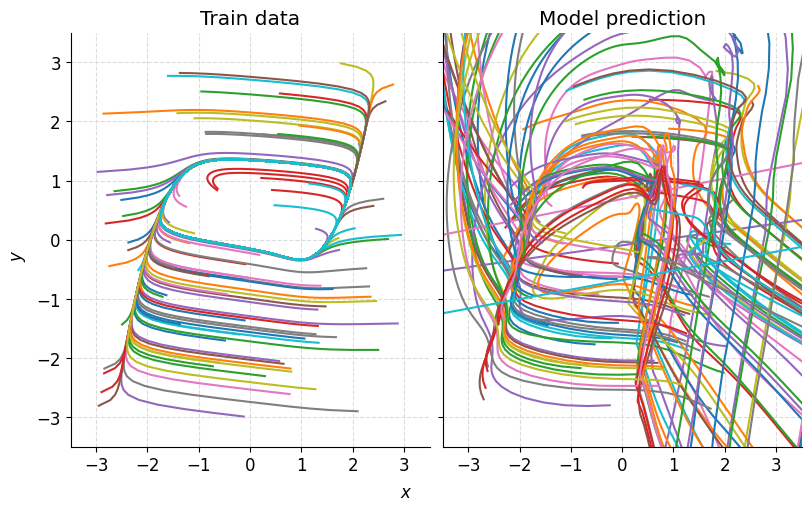

In [20]:
fig, axes = plt.subplots(
    1, 2, figsize=(8, 5), constrained_layout=True, sharex=True, sharey=True
)
for i in range(0, len(u_train_subset), 2):
    axes[0].plot(*u_train_subset[i].T)
    axes[1].plot(*u_pred_subset[i].T)
axes[0].set_xlim((-3.5, 3.5))
axes[0].set_ylim((-3.5, 3.5))
fig.supxlabel("$x$", fontsize="medium")
fig.supylabel("$y$", fontsize="medium")
axes[0].set_title("Train data")
axes[1].set_title("Model prediction")